In [169]:
#Importing needed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

In [170]:
#Extract section :
#campus_id is common between all the feeds and we are going to join on them.
# Each feed extract data for one year at a time. In that way we can create set of plots for each year.

# Extracting percentage of passing per campus
# pct_pass = Percentage pass per campus

def fx_extract_performance(v_year):
    df_performance = pd.read_csv('result_campus.csv')
    rename_dict = {'Campus': 'campus_id' , 'Year' : 'year', 'Pass_rate' : 'pct_pass'}
    df_performance.rename(columns=rename_dict, inplace=True)
    return df_performance

# Extracting average salary, economical disadvantage counts, total number of students
# avg_salary = average salary per campus
# ed_count =economical disadvantage students counts per campus
# student_count = total number of students per campus

def fx_extract_student_teacher(v_year):
    v_filename = 'CAMPPROF_'+ str(v_year) + '.csv'
    df_student_teacher = pd.read_csv(v_filename)
    rename_dict = {"CPSTTOSA": "avg_salary", "CAMPUS": "campus_id","CPETECOC": "ed_count", "CPETALLC" : 'student_count' }
    df_student_teacher.rename(columns=rename_dict, inplace=True)
    df_student_teacher['year'] = [v_year for i,r in df_student_teacher.iterrows() ]
    df_student_teacher =df_student_teacher.loc[:,['campus_id',  'ed_count', 'avg_salary', 'year','student_count']]
    return df_student_teacher

# Extracting community data 
# Data contains district_name,community (rural,Urban,Non-Metro Stable) for campus

def fx_extract_community():
    df_community = pd.read_csv('Community.csv')
    return df_community


In [171]:
# #transform
# Here we are merging all the dataframe into one and adding percentage columns
# pct_ed = percentage of economical disadvange students per compus
# pct_pass = percentage of pass students per campus
# perf_value = sum of pct_ed + pct_pass , used later to calculate the rank
# perf_value_rank = rank to find top 10 performing schools
# student_quartile_value = temporary place holder for storing portion of student population, to find quartile later 
# student_quartile_value_rank = temporary rank place holder for storing rank of student population, to find quartile later 
# student_quartile = assigned quartile based on student population compared to total students

def transform_merge(df_performance,df_student_teacher,df_community):
    # merging data frames by joining on campus_id (and year)
    df_community_performance = pd.merge(df_community,df_performance, on =['campus_id'], how='inner')
    df_community_complete = pd.merge(df_community_performance,df_student_teacher,on =['campus_id','year'], how='inner')
    # Adding pct_ed , perf_value
    df_community_complete['pct_ed'] = [(100*r['ed_count']/r['student_count']) for i, r in df_community_complete.iterrows()]
    df_community_complete['perf_value'] = [r.pct_ed + r.pct_pass for i,r in df_community_complete.iterrows() ]
    # sorting to calculate rank
    DataFrame1_1 = df_community_complete.sort_values(['perf_value'], ascending=False)
    DataFrame1_1.reset_index(inplace=True)
    # perf_value_rank = rank to find top 10 performing schools
    DataFrame1_1['perf_value_rank'] = [i for i,r in DataFrame1_1.iterrows() ]
    student_sum = DataFrame1_1['student_count'].sum() 
    # student_quartile_value = temporary place holder for storing portion of student population, to find quartile later 
    DataFrame1_1['student_quartile_value'] = [r['student_count']/student_sum for i,r in DataFrame1_1.iterrows() ]
    DataFrame1_2 = DataFrame1_1.sort_values(['student_quartile_value'], ascending=False)
    DataFrame1_2.reset_index(inplace=True)
    # student_quartile_value_rank = temporary rank place holder for storing rank of student population, to find quartile later 
    DataFrame1_2['student_quartile_value_rank'] = [i for i,r in DataFrame1_2.iterrows() ]
    student_max_rank = DataFrame1_2['student_quartile_value_rank'].max() 
    # student_quartile = assigned quartile based on student population compared to total students
    DataFrame1_2['student_quartile'] = [1 if r['student_quartile_value_rank']/student_max_rank < .25 else
                                        2 if r['student_quartile_value_rank']/student_max_rank < .50 else
                                        3 if r['student_quartile_value_rank']/student_max_rank < .75 else
                                        4 if r['student_quartile_value_rank']/student_max_rank < 1.00 else -1
                                        for i,r in DataFrame1_2.iterrows() ]

#     DataFrame1_2.reset_index()
    return DataFrame1_2
def fx_economical_disadvantage(df_performance,df_student_teacher,df_community):
    df_community_complete= transform_merge(df_performance,df_student_teacher,df_community)
    #selecting just needed columns
    df_return = df_community_complete.loc[:,['campus_name',  'pct_ed', 'pct_pass' , 'student_quartile' ,'perf_value_rank', 'community', 'year']]
    #cleaning data , duplicates , dropping nulls
    df_return.drop_duplicates()
    df_return = df_return.dropna(how='any')
    return df_return
def fx_salary(df_performance,df_student_teacher,df_community):
    df_community_complete= transform_merge(df_performance,df_student_teacher,df_community)
    #selecting just needed columns
    df_return = df_community_complete.loc[:,['campus_name',  'avg_salary', 'pct_pass' , 'student_quartile' ,'perf_value_rank', 'community', 'year']]
    #cleaning data , duplicates , dropping nulls
    df_return.drop_duplicates()
    df_return = df_return.dropna(how='any')
    return df_return

def fx_community(df_performance,df_community):
    df_community_performance = pd.merge(df_community,df_performance,on = 'campus_id', how='inner')
    unique_community_type = pd.Series(df_community_performance["community"]).unique()
    df_community = pd.DataFrame(unique_community_type,columns=['community'])
    # creating median per community to filter out noise and later used to comparte with percentage pass
    df_community['median_pass'] = [df_community_performance.loc[(df_community_performance['community']==x) , 'pct_pass'].median()  for x in df_community["community"]]
    #cleaning data , duplicates , dropping nulls
    df_community.drop_duplicates()
    df_community = df_community.dropna(how='any')
    return df_community


In [172]:
# plot function 
def fx_bar_plot(DataFrameB, legend_dict):
    x = DataFrameB['x_data']   
    y = DataFrameB['y_data']
    if legend_dict['number_of_y_data'] == 2:
        y2 = DataFrameB['y2_data'] 
    total_mean_list = [y.mean() for i in DataFrameB['x_data']]
    rgb_values = sns.color_palette("Set2", len(DataFrameB['x_data']))
    fig, ax = plt.subplots()
    fig.suptitle(legend_dict['title'], fontsize=15)
    fig.tight_layout() # remove space between header and title
    fig.subplots_adjust(top=.93) # adjust so title is just above chart
    fig.set_size_inches(10, 6)
    y_max_height = ((y.max()//10)*10)+10
    #y_max_height = 100
    y_min_height = ((y.min()//10)*10)-5
    #total_pct_pass = y['pct_pass'].sum()
    #display('total percent pass = ' + total_pct_pass)
    ax.set_ylim(y_min_height, y_max_height, .5)
    bar_width = .75
    bar_columns = ax.bar(x, y, bar_width, color = rgb_values, linewidth=.5, edgecolor=['black']*len(x))
    
    for column in bar_columns:
        height = column.get_height()
        # Attach a text label above each bar displaying its height
        ax.text(column.get_x() + column.get_width()/2, height,
                '%d' % int(height),
                ha='center', va='bottom')
    #total_mean = round(DataFrameB['mean_pass'].mean(),2)
    #print(total_passing_mean)
    #total_mean_list = [total_mean for x in range(0,len(DataFrameB['x_data'])) ]                                                   
    #print(total_pm_list)
    line_label = 'Average = ' + str(round(y.mean(),2))
    ax.plot(x, total_mean_list, '--', color='b', label=line_label) 
    ax.legend(facecolor='lightgray', framealpha=0.5, fancybox=True)   
    ax.set_ylabel(legend_dict['ylabel'], fontsize=12)
    ax.xaxis.grid(color='white', linestyle='solid', linewidth=1)
    ax.yaxis.grid(color='white', linestyle='solid', linewidth=1)
    ax.set_axisbelow(True) # show plots on top of grid lines
    ax.set_facecolor('lightgray')
    ax.tick_params('y', length=0, labelsize=13) # hide tick marks still show lables
    ax.tick_params('x', rotation=90.0, length=0, labelsize=15) # hide tick marks still show lables
    sns.despine(left=True, bottom=True, right=True) # remove border around chart
    #fig.savefig(legend_dict['title'], bbox_inches="tight")
    fig.savefig(legend_dict['filename'] +'.jpg', bbox_inches = 'tight')
    fig.savefig(legend_dict['filename'] +'.png', bbox_inches = 'tight')
    plt.show()

In [173]:
def fx_sal_perf(DataFrame2,legend_dict):
    x = DataFrame2.avg_salary
    y = DataFrame2.pct_pass

    plt.scatter(x,
               y,
               s=40, c='coral', linewidths=1, marker='o',
               alpha=0.8, label='Avg Salary v Performance')

    # Incorporate the other graph properties
    plt.title(legend_dict['title'])
    plt.ylabel(legend_dict['ylabel'])
    plt.xlabel(legend_dict['xlabel'])
    plt.grid(False)

    # Create a legend
    lgnd = plt.legend(fontsize='small', mode='Expanded',
                     numpoints=1, scatterpoints=1,
                     loc='best',labelspacing=0.5)
    lgnd.legendHandles[0]._sizes = [10]

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.tick_params(
       axis='x',          # changes apply to the x-axis
       which='both',      # both major and minor ticks are affected
       bottom='off',      # ticks along the bottom edge are off
       top='off',         # ticks along the top edge are off
       labelbottom='off') # labels along the bottom edge are off

    # Save Figure
    plt.savefig(legend_dict['filename']+'.jpg')
    plt.savefig(legend_dict['filename']+'.png')

    # Show plot
    plt.show()

In [174]:
def fx_perf(DataFrameA,legend_dict ):

    x = DataFrameA.loc[DataFrameA['bubble_size'] == legend_dict['quartile']].x_data
    y = DataFrameA.loc[DataFrameA['bubble_size'] == legend_dict['quartile']].y_data



    plt.scatter(x, 
                y, 
                s=2.5, c=legend_dict['color'], linewidths=1, marker="o", 
                alpha=0.8, label="Quartile "+ str(legend_dict['quartile'])+ "")

    # Incorporate the other graph properties
    plt.title(legend_dict['title'] + "("+ legend_dict['quartile_name']+ ")")
    plt.ylabel(legend_dict['ylabel'])
    plt.xlabel(legend_dict['xlabel'])

    plt.grid(True)

    # Create a legend
    lgnd = plt.legend(fontsize="small", mode="Expanded", 
                      numpoints=1, scatterpoints=1, 
                      loc="best", title="Stu Pop Quartile", 
                      labelspacing=0.5)
    lgnd.legendHandles[0]._sizes = [10]

    plt.xlim(0, 100)
    plt.ylim(0, 100)


    plt.xticks(np.arange(min(x), max(x)+1, 10))
    plt.yticks(np.arange(min(x), max(x)+1, 10))

    fit = np.polyfit(x, y, deg=1)
    plt.plot(x, fit[0] * x + fit[1], color='blue')

    # Save Figure
    plt.savefig("eco_dis_perf_"+ legend_dict['quartile_name']+ ".jpg")
    plt.savefig("eco_dis_perf_"+ legend_dict['quartile_name']+ ".png")

    # Show plot
    plt.show()

In [175]:
def fx_perf_all(DataFrameA,legend_dict):

    x= DataFrameA.loc[DataFrameA['bubble_size'] == 1].x_data
    y = DataFrameA.loc[DataFrameA['bubble_size'] == 1].y_data


    plt.scatter(x, 
                y, 
                s=10, c="gold", 
                edgecolor="black", linewidths=1, marker="o", 
                alpha=0.8, label="Quartile 1")

    x= DataFrameA.loc[DataFrameA['bubble_size'] == 2].x_data
    y = DataFrameA.loc[DataFrameA['bubble_size'] == 2].y_data


    plt.scatter(x, 
                y, 
                s=30, c="skyblue", 
                edgecolor="black", linewidths=1, marker="o", 
                alpha=0.8, label="Quartile 2")



    x= DataFrameA.loc[DataFrameA['bubble_size'] == 3].x_data
    y = DataFrameA.loc[DataFrameA['bubble_size'] == 3].y_data


    plt.scatter(x, 
                y, 
                s=50, c="red", 
                edgecolor="black", linewidths=1, marker="o", 
                alpha=0.8, label="Quartile 3")


    x= DataFrameA.loc[DataFrameA['bubble_size'] == 4].x_data
    y = DataFrameA.loc[DataFrameA['bubble_size'] == 4].y_data



    plt.scatter(x, 
                y, 
                s=70, c="green", 
                edgecolor="black", linewidths=1, marker="o", 
                alpha=0.8, label="Quartile 4")

    # Incorporate the other graph properties
    plt.title(legend_dict['title'])
    plt.ylabel(legend_dict['ylabel'])
    plt.xlabel(legend_dict['xlabel'])
    plt.grid(True)

    # Create a legend
    lgnd = plt.legend(fontsize="small", mode="Expanded", 
                      numpoints=1, scatterpoints=1, 
                      loc="best", title="Stu Pop Quartile", 
                      labelspacing=0.5)
    lgnd.legendHandles[0]._sizes = [10]
    lgnd.legendHandles[1]._sizes = [30]
    lgnd.legendHandles[2]._sizes = [50]
    lgnd.legendHandles[2]._sizes = [70]


    plt.xlim(0, 100)
    plt.ylim(0, 100)


    # Incorporate a text label regarding circle size
    plt.text(105, 90, "Circle size correlates to \nPercentile of Student Population.")

    # Save Figure
    plt.savefig(legend_dict['filename'] +'.jpg')
    plt.savefig(legend_dict['filename'] +'.png')
    # Show plot
    plt.show()

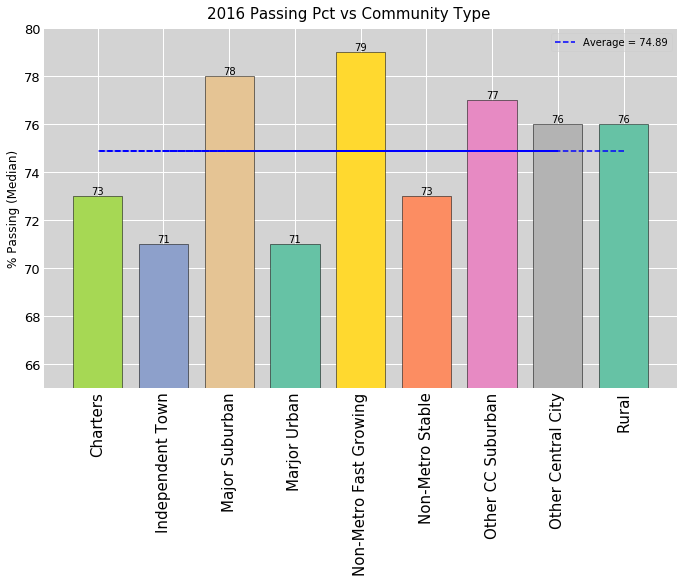

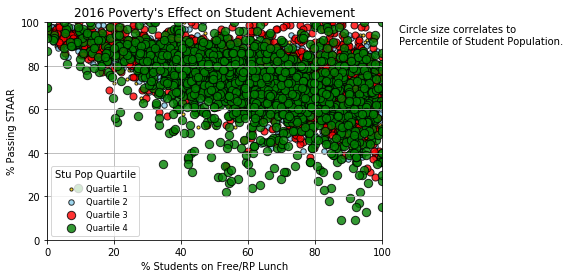

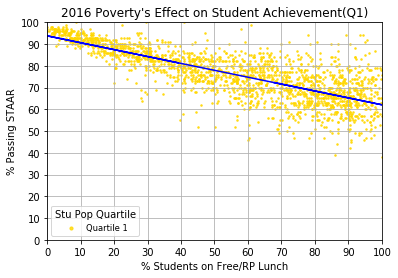

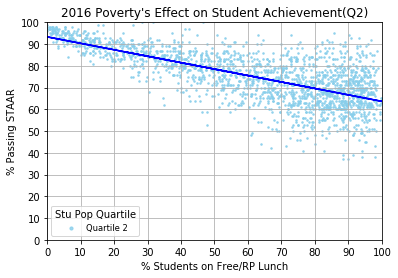

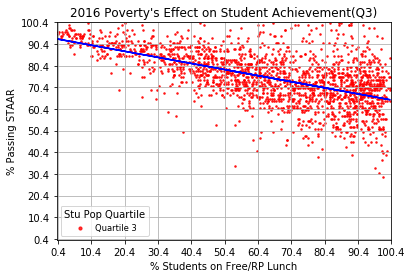

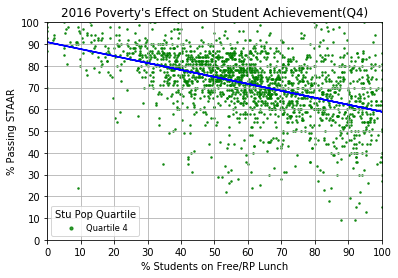

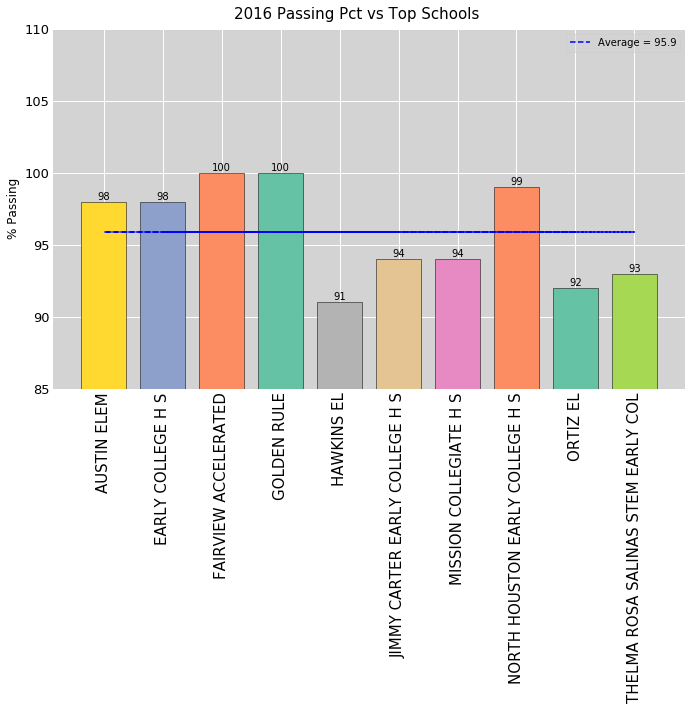

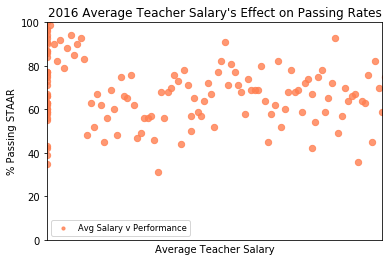

In [176]:
# calling data in loop for each year
for v_interested_year in [2016]:
    #extract performance (pct_pass) data 
    df_performance = fx_extract_performance(v_interested_year)
    #extract student/staff data ('campus_name',  'avg_salary', 'pct_pass' , 'student_quartile' ,'perf_value_rank', 'community', 'year')
    df_student_teacher = fx_extract_student_teacher(v_interested_year)
    df_community = fx_extract_community()
    #transform function calls 
    DataFrame1 = fx_economical_disadvantage(df_performance,df_student_teacher,df_community)
    DataFrame2 = fx_salary(df_performance,df_student_teacher,df_community)
    DataFrame3 = fx_community(df_performance,df_community)
    #### Community bar plot call 
    legend_dict = {'title' : str(v_interested_year) + ' Passing Pct vs Community Type',
                   'ylabel' : '% Passing (Median)',
                   'figname' : str(v_interested_year) +' passing_vs_community',
                   'high_ylim' : 85 , 'low_ylim' : 65 , 'number_of_y_data' : 1,
                   'filename' : str(v_interested_year)+'_community_perf'
                  }
    DataFrameB =DataFrame3.loc[:,['community','median_pass']]
    rename_dict = {'community': 'x_data', 'median_pass': 'y_data'}
    DataFrameB.rename(columns=rename_dict, inplace=True)
    fx_bar_plot(DataFrameB, legend_dict)
    #### pct Economically disadvantage vs performance all plot 
    DataFrameA = DataFrame1.loc[:, ['pct_ed', 'pct_pass', 'student_quartile', 'community' , 'perf_value_rank','campus_name']]
    rename_dict = {'pct_ed': 'x_data', 'pct_pass': 'y_data', 'student_quartile': 'bubble_size',
                  'community': 'color_category' }
    DataFrameA.rename(columns=rename_dict, inplace=True)

    legend_dict = { 
                  'title' : str(v_interested_year)+" Poverty's Effect on Student Achievement",
                  'ylabel' : "% Passing STAAR",
                  'xlabel' : "% Students on Free/RP Lunch",
                  'filename' : str(v_interested_year)+'_eco_dis_perf'
                 }

    fx_perf_all(DataFrameA,legend_dict )
    #### pct Economically disadvantage vs performance q1 plot 
    legend_dict = { 'quartile' : 1,
                    'quartile_name' : 'Q1',
                  'title' : str(v_interested_year)+" Poverty's Effect on Student Achievement",
                  'ylabel' : "% Passing STAAR",
                   'color' : 'gold',
                  'xlabel' : "% Students on Free/RP Lunch",
                  'filename' : str(v_interested_year)+'_eco_dis_perf'
                 }
    fx_perf(DataFrameA,legend_dict)
    #### pct Economically disadvantage vs performance q2 plot 
    legend_dict = { 'quartile' : 2,
                    'quartile_name' : 'Q2',
                  'title' : str(v_interested_year)+" Poverty's Effect on Student Achievement",
                  'ylabel' : "% Passing STAAR",
                   'color' : 'skyblue',
                  'xlabel' : "% Students on Free/RP Lunch",
                  'filename' : str(v_interested_year)+'_eco_dis_perf'
                 }
    fx_perf(DataFrameA,legend_dict)

    #### pct Economically disadvantage vs performance q3 plot 
    legend_dict = { 'quartile' : 3,
                    'quartile_name' : 'Q3',
                  'title' : str(v_interested_year)+" Poverty's Effect on Student Achievement",
                  'ylabel' : "% Passing STAAR",
                   'color' : 'red',
                  'xlabel' : "% Students on Free/RP Lunch",
                  'filename' : str(v_interested_year)+'_eco_dis_perf'
                 }
    fx_perf(DataFrameA,legend_dict)

    #### pct Economically disadvantage vs performance q4 plot 
    legend_dict = { 'quartile' : 4,
                    'quartile_name' : 'Q4',
                  'title' : str(v_interested_year)+" Poverty's Effect on Student Achievement",
                  'ylabel' : "% Passing STAAR",
                   'color' : 'green',
                  'xlabel' : "% Students on Free/RP Lunch",
                  'filename' : str(v_interested_year)+'_eco_dis_perf'
                 }
    fx_perf(DataFrameA,legend_dict)

    #### pct Economically disadvantage/ pct passing for top 10 campuses 
    legend_dict = {'title' : str(v_interested_year) + ' Passing Pct vs Top Schools',
                   'ylabel' : '% Passing',
                   'figname' : str(v_interested_year) +' Passing Pct vs Top Schools',
                   'high_ylim' : 100 , 'low_ylim' : 80, 'number_of_y_data' : 2,
                   'filename' : str(v_interested_year)+'_ed_top_schools'
                  }
    DataFrameC =DataFrameA.loc[(DataFrameA['perf_value_rank'] < 10),['campus_name','y_data','x_data']]
    rename_dict = {'campus_name': 'x_data', 'y_data': 'y_data' , 'x_data' : 'y2_data'}
    DataFrameC.rename(columns=rename_dict, inplace=True)
    fx_bar_plot(DataFrameC, legend_dict)
    #### average salary of teachers vs performance accross all campuses
    legend_dict = {'title' : str(v_interested_year) + " Average Teacher Salary's Effect on Passing Rates",
                   'ylabel' : '% Passing STAAR',
                   'xlabel' : "Average Teacher Salary",
                   'filename' : str(v_interested_year)+'_sal_perf'
                  }
    DataFrame2 = fx_salary(df_performance,df_student_teacher,df_community)
    fx_sal_perf(DataFrame2,legend_dict)

